# QQQ Next‑Day Return Prediction with LSTM

## 1. Setup & Dependencies

In [101]:
import pandas as pd
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
print("TensorFlow:", tf.__version__)
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

TensorFlow: 2.19.0


## 2. Data Ingestion

In [102]:
df = pd.read_csv('data/data_for_LSTM/QQQ.csv')

# Rename for convenience
df = df.rename(columns={
    'open_price':'open',
    'high_price':'high',
    'low_price':'low',
    'close_price':'close',
    'adj_close_price':'adj_close',
    'trading_volume':'volume'
})
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df = df[df['date'] >= '2023-01-01']
df = df[df['date'] <= '2023-12-31']
df = df.drop(columns=['outstanding_shares', 'adj_factor', 'market_cap'])
df.head()

,ticker,date,open,high,low,close,adj_close,volume
5535,QQQ,2023-01-03,268.65,270.155,262.13,264.48,264.48,42193460.0
5536,QQQ,2023-01-04,266.64,267.450,262.53,265.74,265.74,47390390.0
5537,QQQ,2023-01-05,264.04,264.210,261.26,261.58,261.58,44495950.0
5538,QQQ,2023-01-06,263.35,269.940,260.34,268.80,268.80,54551510.0
5539,QQQ,2023-01-09,270.83,275.290,269.92,270.54,270.54,45320030.0


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 5535 to 5784
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ticker     250 non-null    object        
 1   date       250 non-null    datetime64[ns]
 2   open       250 non-null    float64       
 3   high       250 non-null    float64       
 4   low        250 non-null    float64       
 5   close      250 non-null    float64       
 6   adj_close  250 non-null    float64       
 7   volume     250 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 17.6+ KB


In [104]:
sentiment_df = pd.read_csv('data/data_for_LSTM/sentiment/nasdaq_100_daily_sentiment.csv')
sentiment_df = sentiment_df.rename(columns={
    'Date':'date',
    'SentimentScore':'sentiment_score',
    'Ticker':'ticker'
})
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
df = pd.merge(df, sentiment_df, on='date', how='left')
df.head()


,ticker,date,open,high,low,close,adj_close,volume,Nasdaq100_Weighted_Sentiment,SentimentCoverageRatio,3_day_rolling_sentiment,5_day_rolling_sentiment,7_day_rolling_sentiment
0,QQQ,2023-01-03,268.65,270.155,262.13,264.48,264.48,42193460.0,0.083663,0.591425,0.083663,0.083663,0.083663
1,QQQ,2023-01-04,266.64,267.450,262.53,265.74,265.74,47390390.0,0.190146,0.640182,0.136904,0.136904,0.136904
2,QQQ,2023-01-05,264.04,264.210,261.26,261.58,261.58,44495950.0,0.226121,0.624121,0.166643,0.166643,0.166643
3,QQQ,2023-01-06,263.35,269.940,260.34,268.80,268.80,54551510.0,0.560479,0.611186,0.325582,0.265102,0.265102
4,QQQ,2023-01-09,270.83,275.290,269.92,270.54,270.54,45320030.0,0.470395,0.616958,0.418998,0.306161,0.306161


## 3. Feature Engineering
We construct a rich set of signals widely used in systematic trading strategies. All features are computed **only with information available up to time *t‑1*** to avoid look‑ahead bias.

| Signal                           | Description                                               |
|----------------------------------|-----------------------------------------------------------|
| Daily return                     | $r_t = (P_t / P_{t-1}) - 1$                               |
| Volatility 20d                   | Rolling 20‑day std of returns                             |
| Momentum 10d                     | $P_t / P_{t-10} - 1$                                      |
| SMA / EMA                        | Simple & Exponential moving averages (5, 20, 50, 100)     |
| Price / SMA Ratio                | Ratio of current price to its Simple Moving Average       |
| MACD (Value, Signal, Hist)       | 12‑26‑9 exponential moving‑average oscillator components  |
| RSI 14d                          | Relative Strength Index                                   |
| Bollinger %B                     | Position of price within 20‑day Bollinger Band            |
| Z‑Score 20d                      | Mean‑reversion score: $(P_t - \mu_{20}) / \sigma_{20}$    |
| Stochastic Oscillator (%K, %D)   | Momentum indicator comparing closing price to price range |
| ATR 14d                          | Average True Range (volatility measure)                   |
| OBV                              | On‑Balance Volume                                         |
| Volume Z-Score 20d               | Standardized 20-day rolling volume                        |
| Nasdaq100_Weighted_Sentiment     | Weighted sentiment score for Nasdaq 100 components        |
| 3_day_rolling_sentiment          | 3-day rolling average of a sentiment score                |
| 5_day_rolling_sentiment          | 5-day rolling average of a sentiment score                |
| 7_day_rolling_sentiment          | 7-day rolling average of a sentiment score                |

In [105]:
def compute_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

def compute_stochastic(high, low, close, k_window: int = 14, d_window: int = 3):
    lowest_low = low.rolling(k_window).min()
    highest_high = high.rolling(k_window).max()
    percent_k = 100 * (close - lowest_low) / (highest_high - lowest_low)
    percent_d = percent_k.rolling(d_window).mean()
    return percent_k, percent_d

def compute_atr(high, low, close, window: int = 14) -> pd.Series:
    high_low = high - low
    high_close = (high - close.shift()).abs()
    low_close = (low - close.shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(window).mean()

def compute_obv(close, volume) -> pd.Series:
    direction = np.sign(close.diff()).fillna(0)
    return (volume * direction).cumsum()

# ---------- feature engineering ----------
def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # basic returns & momentum
    out["ret_1d"]  = out["adj_close"].pct_change()
    out["ret_5d"]  = out["adj_close"].pct_change(5)
    out["ret_20d"] = out["adj_close"].pct_change(20)
    out["mom_10d"] = out["adj_close"].pct_change(10)
    out["mom_20d"] = out["adj_close"].pct_change(20)

    # volatility
    out["vol_20d"] = out["ret_1d"].rolling(20).std()
    out["vol_60d"] = out["ret_1d"].rolling(60).std()

    # moving-average features
    for win in [5, 10, 20, 50, 100]:
        out[f"sma_{win}"] = out["adj_close"].rolling(win).mean()
        out[f"ema_{win}"] = out["adj_close"].ewm(span=win, adjust=False).mean()
        out[f"price_sma_ratio_{win}"] = out["adj_close"] / out[f"sma_{win}"]

    # Bollinger-band statistics
    ma20  = out["adj_close"].rolling(20).mean()
    std20 = out["adj_close"].rolling(20).std()
    upper = ma20 + 2 * std20
    lower = ma20 - 2 * std20
    out["pctB"]       = (out["adj_close"] - lower) / (upper - lower)
    out["zscore_20"]  = (out["adj_close"] - ma20) / std20

    # MACD
    ema12 = out["adj_close"].ewm(span=12, adjust=False).mean()
    ema26 = out["adj_close"].ewm(span=26, adjust=False).mean()
    out["macd"]        = ema12 - ema26
    out["macd_signal"] = out["macd"].ewm(span=9, adjust=False).mean()
    out["macd_hist"]   = out["macd"] - out["macd_signal"]

    # RSI
    out["rsi_14"] = compute_rsi(out["adj_close"], 14)

    # Stochastic Oscillator
    out["stoch_k"], out["stoch_d"] = compute_stochastic(
        out["high"], out["low"], out["adj_close"]
    )

    # ATR
    out["atr_14"] = compute_atr(out["high"], out["low"], out["adj_close"])

    # OBV & volume z-score
    out["obv"]     = compute_obv(out["adj_close"], out["volume"])
    out["vol_z_20"] = (
        (out["volume"] - out["volume"].rolling(20).mean()) /
        out["volume"].rolling(20).std()
    )

    return out

# apply feature set
df_feat = add_technical_indicators(df)

# target: next-day return (no look-ahead bias)
df_feat["ret_fwd_1d"] = df_feat["ret_1d"].shift(-1)

# explicit list of usable features
feature_cols = [
    c for c in df_feat.columns
    if c not in {
        "ret_fwd_1d", "open", "close", 
        "high", "low", "volume", 'SentimentCoverageRatio',
        "ticker", "adj_factor", "date", "outstanding_shares"
    }
]

# final cleanup
df_feat = df_feat.dropna().copy()



# Uncomment to drop sentiment features to test the model without sentiment
#df_feat = df_feat.drop(columns=['Nasdaq100_Weighted_Sentiment', '3_day_rolling_sentiment', '5_day_rolling_sentiment', '7_day_rolling_sentiment'])

feature_cols


['adj_close',
 'Nasdaq100_Weighted_Sentiment',
 '3_day_rolling_sentiment',
 '5_day_rolling_sentiment',
 '7_day_rolling_sentiment',
 'ret_1d',
 'ret_5d',
 'ret_20d',
 'mom_10d',
 'mom_20d',
 'vol_20d',
 'vol_60d',
 'sma_5',
 'ema_5',
 'price_sma_ratio_5',
 'sma_10',
 'ema_10',
 'price_sma_ratio_10',
 'sma_20',
 'ema_20',
 'price_sma_ratio_20',
 'sma_50',
 'ema_50',
 'price_sma_ratio_50',
 'sma_100',
 'ema_100',
 'price_sma_ratio_100',
 'pctB',
 'zscore_20',
 'macd',
 'macd_signal',
 'macd_hist',
 'rsi_14',
 'stoch_k',
 'stoch_d',
 'atr_14',
 'obv',
 'vol_z_20']

### 3.1 Feature Correlation Heatmap

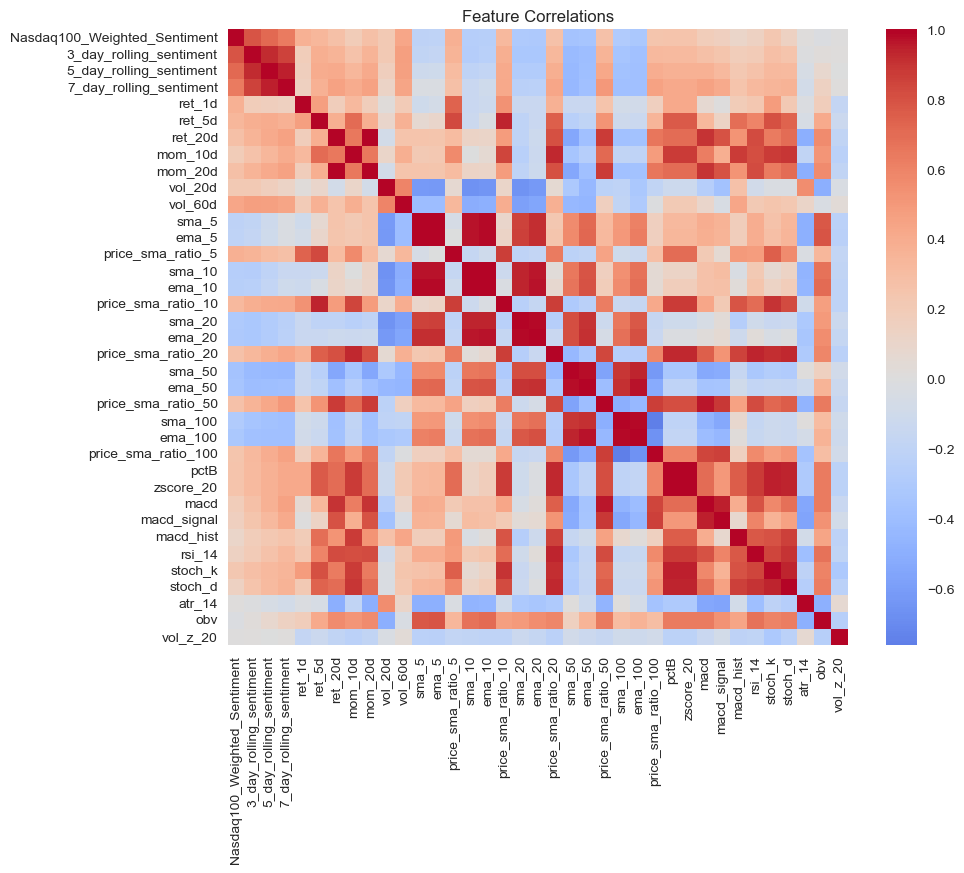

In [106]:

plt.figure(figsize=(10,8))
sns.heatmap(X_feat.corr(), cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.show()


## 4. Train / Test Split & Scaling

In [107]:
# Chronological split: first 80% for training, last 20% for testing
split = int(len(df_feat)*0.8)
train_df = df_feat.iloc[:split]
test_df = df_feat.iloc[split:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[feature_cols])
test_scaled = scaler.transform(test_df[feature_cols])

y_train = train_df['ret_fwd_1d'].values
y_test = test_df['ret_fwd_1d'].values

# Sequence length (look‑back window)
SEQ_LEN = 3

def to_sequences(X, y, seq_len=SEQ_LEN):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_train, y_train_seq = to_sequences(train_scaled, y_train)
X_test, y_test_seq = to_sequences(test_scaled, y_test)

print("Train sequences:", X_train.shape, "Test sequences:", X_test.shape)


Train sequences: (117, 3, 38) Test sequences: (27, 3, 38)


## 5. Build & Train LSTM

In [108]:
tf.keras.backend.clear_session()

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)  # regression output (next‑day return)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

EPOCHS = 300
BATCH_SIZE = 2048

history = model.fit(
    X_train, y_train_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    
    validation_split=0.2,
    verbose=1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 64)          │        26,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,817 (151.63 KB)

 Trainable params: 38,817 (151.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0175 - val_loss: 0.0055
Epoch 2/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0057 - val_loss: 1.9204e-04
Epoch 3/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0066 - val_loss: 0.0031
Epoch 5/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0076 - val_loss: 0.0025
Epoch 6/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0062 - val_loss: 0.0012
Epoch 7/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0046 - val_loss: 3.3101e-04
Epoch 8/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0020 - val_loss: 3.2143e-04
Epoch 9/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 10/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 11/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 12/300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.003

### 5.1 Training Curves

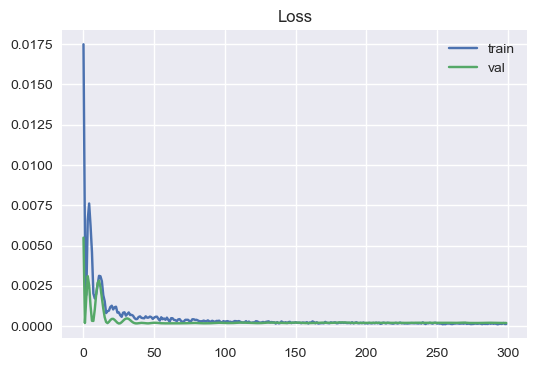

In [109]:

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title('Loss')
plt.show()


## 6. Prediction & Evaluation

In [110]:
# Predict next‑day returns on the test set
y_pred = model.predict(X_test).flatten()

rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))

print(f"Test RMSE: {rmse:.6f}")

# Directional accuracy
direction_acc = np.mean(np.sign(y_pred) == np.sign(y_test_seq))
print(f"Sign prediction accuracy: {direction_acc:.2%}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Test RMSE: 0.008338
Sign prediction accuracy: 62.96%


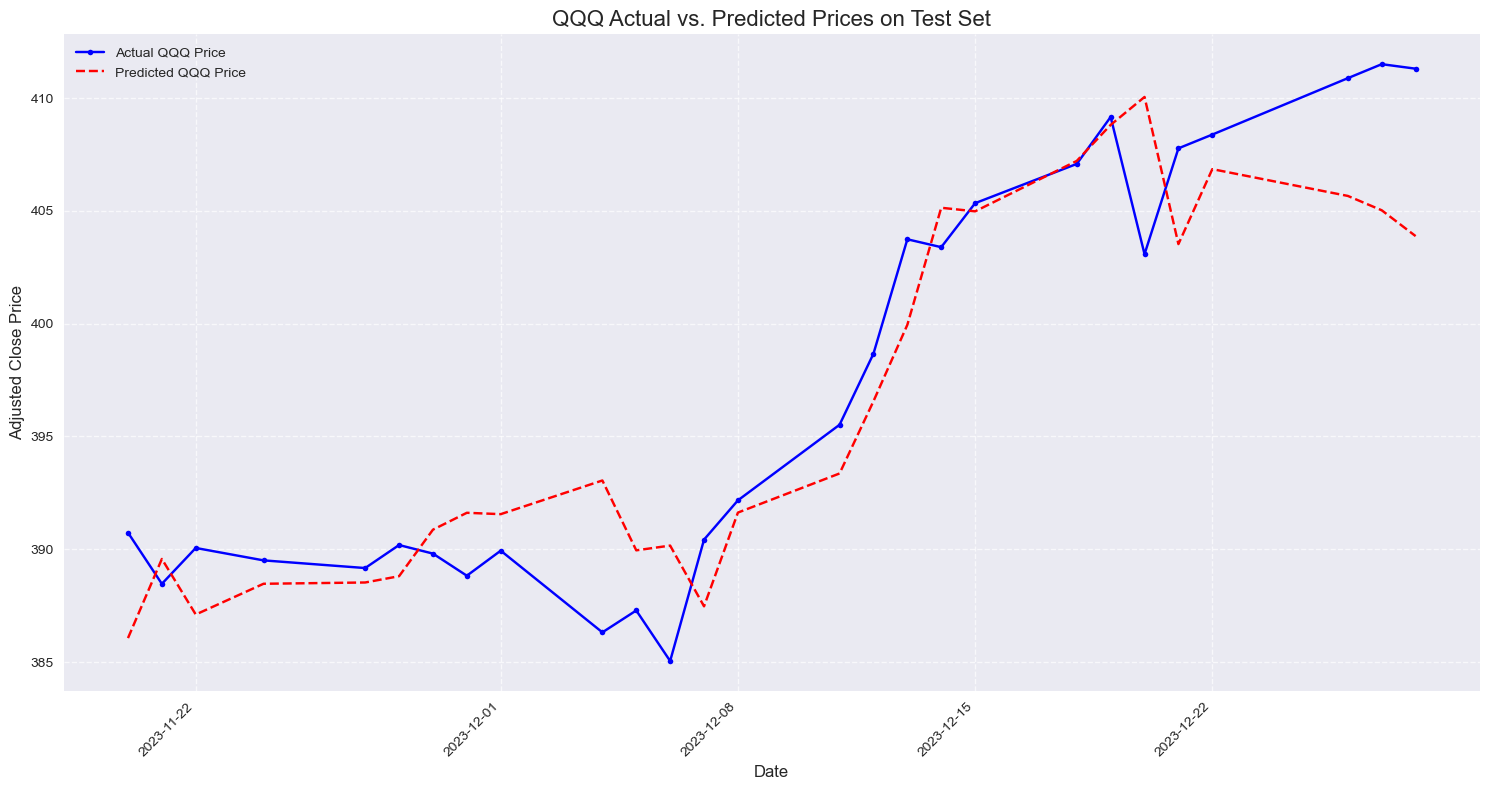

In [111]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Number of predictions
num_predictions = len(y_pred)


plot_dates = test_df['date'].iloc[SEQ_LEN : SEQ_LEN + num_predictions]

# Get the actual QQQ prices for these dates. This is what we plot against.
actual_prices_to_plot = test_df['adj_close'].iloc[SEQ_LEN : SEQ_LEN + num_predictions].values

# Get the actual QQQ prices from the day *before* each prediction.
# This will be the base price to which we apply the predicted return.
# P_base_for_pred_i = Price_at_ (plot_dates[i] - 1 day)
previous_day_actual_prices = test_df['adj_close'].iloc[SEQ_LEN - 1 : SEQ_LEN - 1 + num_predictions].values

# Calculate the predicted QQQ price levels
# PredictedPrice_on_plot_dates[i] = Price_on_ (plot_dates[i]-1) * (1 + y_pred[i])
predicted_prices_to_plot = previous_day_actual_prices * (1 + y_pred)

# --- Plotting ---
plt.figure(figsize=(15, 8))
plt.plot(plot_dates, actual_prices_to_plot, label='Actual QQQ Price', color='blue', marker='o', markersize=4, linestyle='-')
plt.plot(plot_dates, predicted_prices_to_plot, label='Predicted QQQ Price', color='red', marker='x', markersize=4, linestyle='--')

plt.title('QQQ Actual vs. Predicted Prices on Test Set', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adjusted Close Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Improve date formatting on x-axis if plot_dates is a DatetimeIndex or similar
plt.xticks(rotation=45, ha='right')

plt.tight_layout() # Adjust layout to make room for rotated x-axis labels
plt.show()